In [58]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [59]:
!ls

!ls md

!ls md/btcusdt:Binance:LinearPerpetual

'EDA Dolmatov.ipynb'   md   plots.py
btcusdt:Binance:LinearPerpetual  ethusdt:Binance:LinearPerpetual
lobs.csv  trades.csv


In [60]:
def read_btc(nrows=100000):
    
    lobs = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/lobs.csv', nrows=nrows)

    trades = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/trades.csv', nrows=nrows)

    names = lobs.columns.values
    ln = len('btcusdt:Binance:LinearPerpetual_')
    renamer = { name:name[ln:] for name in names[2:]}
    renamer[' exchange_ts'] = 'exchange_ts'
    lobs.rename(renamer, axis=1, inplace=True)
    
    lobs["exchange_dt"] = pd.to_datetime(lobs.exchange_ts)
    trades["exchange_dt"] = pd.to_datetime(trades.exchange_ts)
    
    return lobs, trades

In [61]:
lobs, trades = read_btc(1e5)

In [62]:
ask_columns = list(filter(lambda x: x.startswith('ask'), lobs.columns.values))

bid_columns = list(filter(lambda x: x.startswith('bid'), lobs.columns.values))

dt_columns = list(set(lobs.columns) - set(ask_columns) - set(bid_columns))

In [63]:
ask_lobs = lobs[dt_columns + ask_columns].rename({name : name[4:] for name in ask_columns}, axis=1).drop(['receive_ts', 'exchange_ts'], axis=1)
bid_lobs = lobs[dt_columns + bid_columns].rename({name : name[4:] for name in bid_columns}, axis=1).drop(['receive_ts', 'exchange_ts'], axis=1)

In [64]:
def get_cum_volume(df):
    N_steps = 10
    S = np.zeros((df.shape[0], ))
    for i in range(N_steps):
        S += df[f'vol_{i}'].values
        df[f"vol_cum_{i}"] = S
    return df

In [65]:
bid_lobs = get_cum_volume(bid_lobs)
ask_lobs = get_cum_volume(ask_lobs)

In [66]:
len(bid_lobs), len(ask_lobs)

(100000, 100000)

In [67]:
bid_trades = trades[trades.aggro_side == 'BID'].drop(["aggro_side", "exchange_ts", "receive_ts"], axis=1).reset_index(drop=True)

ask_trades = trades[trades.aggro_side == 'ASK'].drop(["aggro_side", "exchange_ts", "receive_ts"], axis=1).reset_index(drop=True)

In [68]:
N = 1000
T = trades.exchange_ts[N]

In [69]:
lobs_ = lobs[lobs.exchange_ts < T]

trades_ = trades[:N]

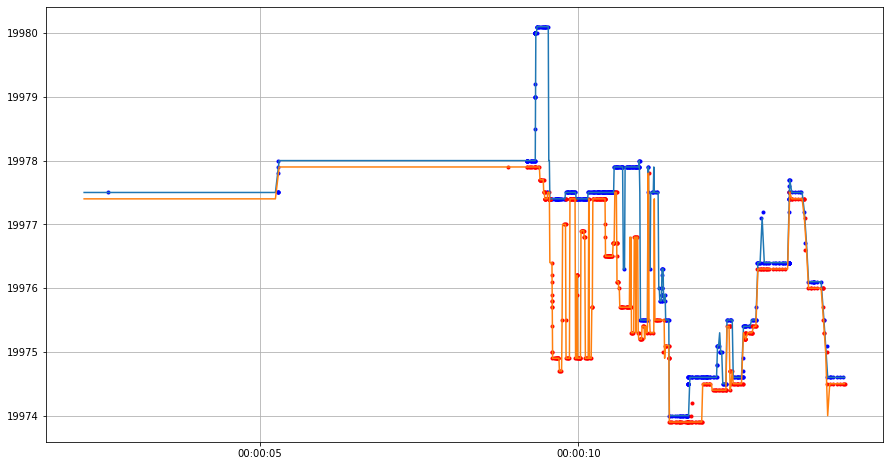

In [70]:
plt.figure(figsize=(15, 8))
plt.plot(trades_.exchange_dt[trades_.aggro_side == 'BID'], trades_.price[trades_.aggro_side == 'BID'], 'b.')
plt.plot(trades_.exchange_dt[trades_.aggro_side == 'ASK'], trades_.price[trades_.aggro_side == 'ASK'], 'r.')
plt.plot(lobs_.exchange_dt, lobs_.ask_price_0)
plt.plot(lobs_.exchange_dt, lobs_.bid_price_0)
plt.grid()

In [71]:
bid_trades

,price,size,exchange_dt
0,19977.5,0.001,2022-06-23 00:00:02.623
1,19977.5,0.041,2022-06-23 00:00:05.292
2,19977.5,0.036,2022-06-23 00:00:05.292
3,19977.5,0.001,2022-06-23 00:00:05.292
4,19977.5,0.001,2022-06-23 00:00:05.292
...,...,...,...
52839,20169.4,0.117,2022-06-23 00:16:20.680
52840,20169.4,0.122,2022-06-23 00:16:20.855
52841,20169.4,0.098,2022-06-23 00:16:20.855
52842,20169.4,0.002,2022-06-23 00:16:20.927


In [72]:
ask_trades

,price,size,exchange_dt
0,19977.9,0.020,2022-06-23 00:00:08.890
1,19977.9,0.061,2022-06-23 00:00:09.193
2,19977.9,0.172,2022-06-23 00:00:09.193
3,19977.9,0.032,2022-06-23 00:00:09.233
4,19977.9,0.021,2022-06-23 00:00:09.244
...,...,...,...
47151,20169.1,0.003,2022-06-23 00:16:21.068
47152,20169.0,0.002,2022-06-23 00:16:21.068
47153,20168.9,0.001,2022-06-23 00:16:21.068
47154,20168.2,0.002,2022-06-23 00:16:21.068


## 2. Статистики размеров трейда 

In [73]:
def get_statistics(data):
    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    q05 = np.quantile(data, 0.05)
    q25 = np.quantile(data, 0.25)
    q75 = np.quantile(data, 0.75)
    q95 = np.quantile(data, 0.95)
    
    _max = np.max(data)
    
    interq = q75 - q25
    rang   = q95 - q05
    
    
    from collections import Counter
    items = [ (fst, scnd) for fst, scnd in Counter(data).items()]
    items = sorted(items)

    sizes = [fst for fst, _ in items]
    count = [scnd for _, scnd in items]
    
    Q1 = count[0] / np.sum(count)
    Q2 = count[1] / np.sum(count)
    Q3 = count[2] / np.sum(count)
    
    S1 = sizes[0]
    S2 = sizes[1]
    S3 = sizes[2]
    
    names = ["mean", "std", "median", "q05", "q25", "q75", "q95", "max", "inq", "range", "Q1", "Q2", "Q3"]
    values = [mean, std, median, q05, q25, q75, q95, _max, interq, rang, Q1, Q2, Q3]
    
    return names, values

In [74]:
names, bid_values = get_statistics(bid_trades['size'])
_, ask_values = get_statistics(ask_trades['size'])

print("\tBid Statistics \t\t\t Ask Statistics")

for name, bid_val, ask_val in zip(names, bid_values, ask_values):
    print(f"{name} \t {bid_val:4f} \t\t\t {ask_val:4f}")

	Bid Statistics 			 Ask Statistics
mean 	 0.131869 			 0.130910
std 	 0.628218 			 0.388013
median 	 0.015000 			 0.016000
q05 	 0.001000 			 0.001000
q25 	 0.002000 			 0.001000
q75 	 0.100000 			 0.102000
q95 	 0.568850 			 0.600000
max 	 63.004000 			 14.843000
inq 	 0.098000 			 0.101000
range 	 0.567850 			 0.599000
Q1 	 0.237302 			 0.250233
Q2 	 0.046741 			 0.051574
Q3 	 0.023655 			 0.020273


Q1 это доля трейдов, у которых размер равнялся 0.001(минимальному размеру)
Q2 -- доля трейдов объёма 0.002, Q3 -- доля трейдов объема 0.003

### Статистики для объема на лучшем bid/aks уровне.

In [75]:
names, bid_values = get_statistics(bid_lobs.vol_cum_0)
_, ask_values =  get_statistics(ask_lobs.vol_cum_0)

print("\tBid Statistics \t\t\t Ask Statistics")

for name, bid_val, ask_val in zip(names[:-3], bid_values[:-3], ask_values[:-3]):
    print(f"{name} \t {bid_val:4f} \t\t\t {ask_val:4f}")

	Bid Statistics 			 Ask Statistics
mean 	 2.247488 			 2.283125
std 	 5.231526 			 3.685271
median 	 0.854000 			 0.938000
q05 	 0.004000 			 0.006000
q25 	 0.194000 			 0.205000
q75 	 2.844000 			 3.007000
q95 	 8.624050 			 8.847000
max 	 483.565000 			 126.695000
inq 	 2.650000 			 2.802000
range 	 8.620050 			 8.841000


## 3а. Гистограммы частот объёмов продаж/покупок в логарифмическом масштабе.

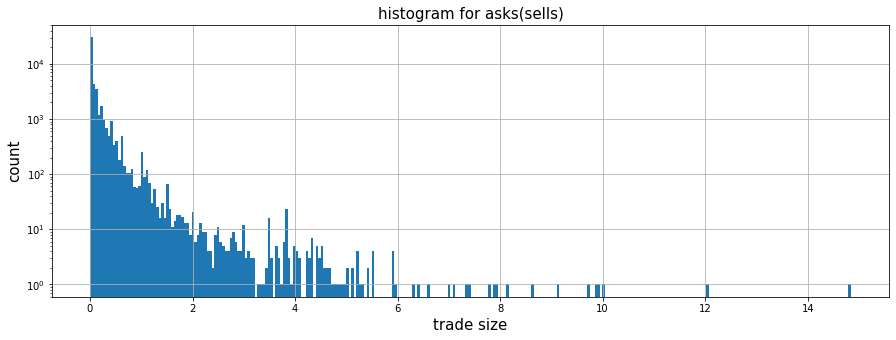

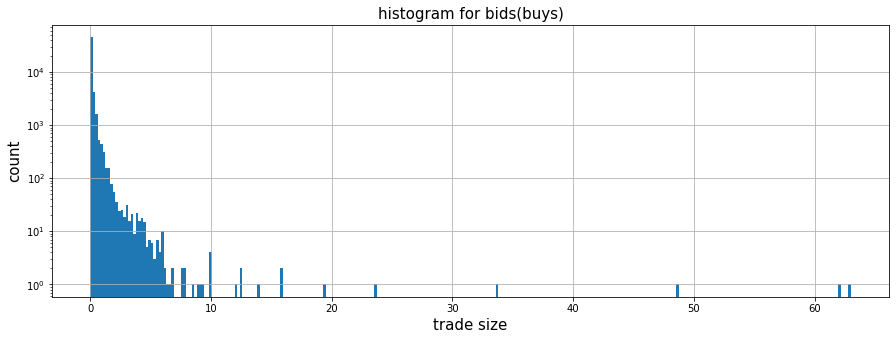

In [76]:
bid_size = bid_trades['size'].values
ask_size = ask_trades['size'].values

plt.figure(figsize=(15, 5))
plt.hist(ask_size, bins=300, log=True)
plt.title("histogram for asks(sells)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()
plt.figure(figsize=(15, 5))
plt.hist(bid_size, bins=300, log=True)
plt.title("histogram for bids(buys)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()

Те же самые гистограммы, только без 5% наибольших значений.

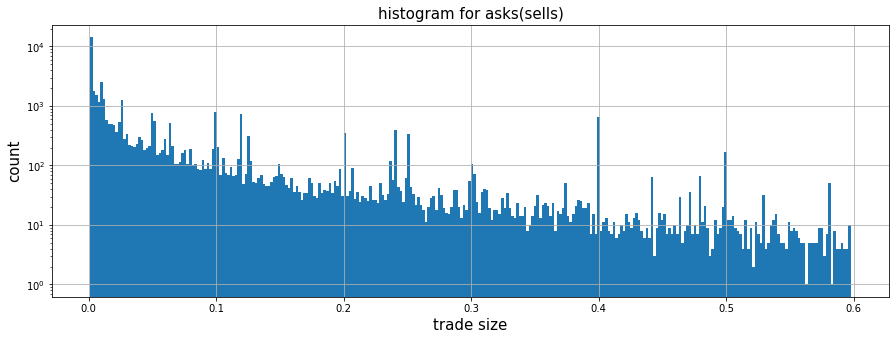

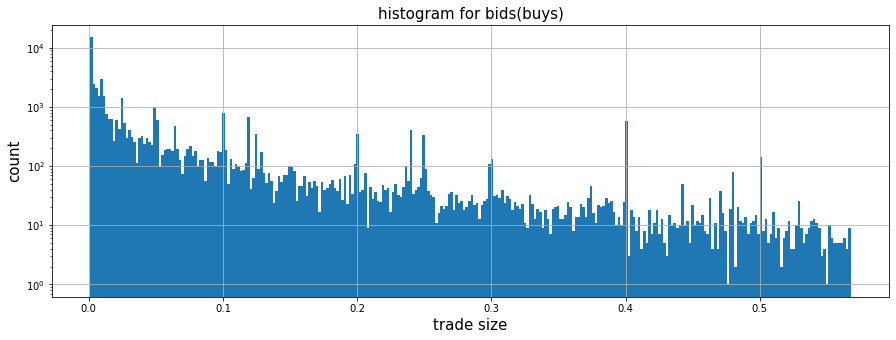

In [77]:
q1 = np.quantile(ask_size, 0.95)
q2 = np.quantile(bid_size, 0.95)

plt.figure(figsize=(15, 5))
plt.hist(ask_size[ask_size < q1], bins=300, log=True)
plt.title("histogram for asks(sells)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()
plt.figure(figsize=(15, 5))
plt.hist(bid_size[bid_size < q2], bins=300, log=True)
plt.title("histogram for bids(buys)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()

## 3.б Гистограммы для кумулятивных объёмов стаканов

In [78]:
def plot_volume_hist(df):
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    for i in range(6):
        vals = df[f'vol_cum_{i}']
        q = np.quantile(vals, 0.99)
        vals = vals[vals < q]
        ax[i // 2, i % 2].hist(vals, bins=200, log=False, density=False)
        ax[i // 2, i % 2].grid()

        ax[i // 2, i % 2].set_title(f"Histogram of volume at level {i}", fontsize=15)
        ax[i // 2, i % 2].set_xlabel("volume", fontsize=10)
    plt.show()

### Bid side

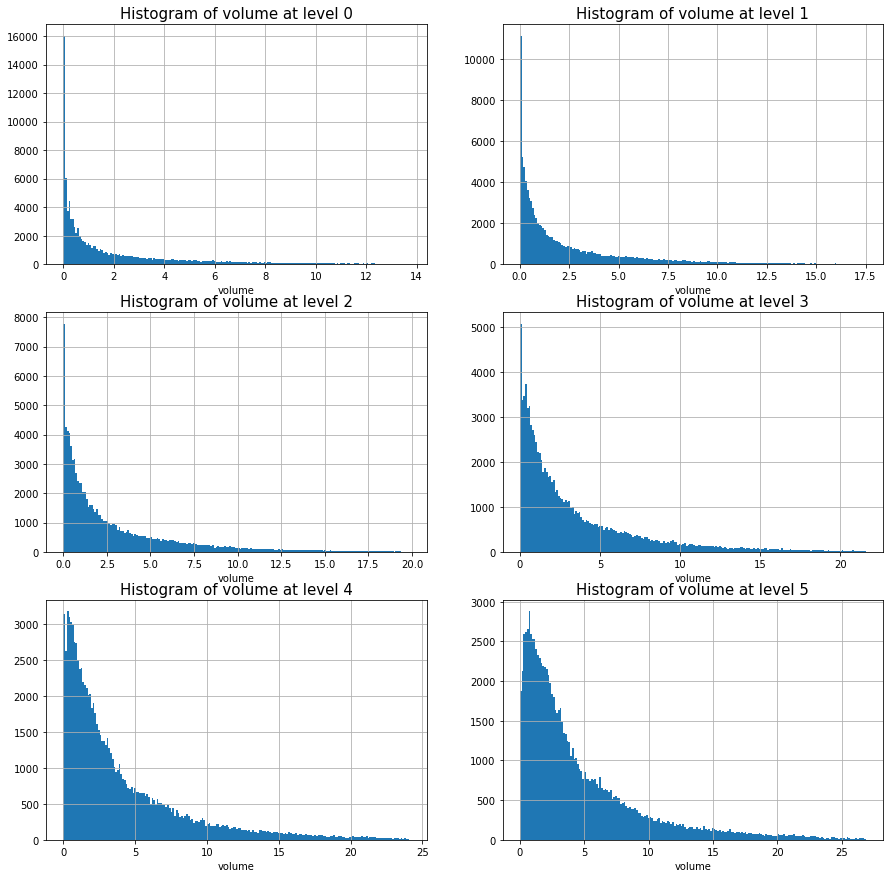

In [79]:
plot_volume_hist(bid_lobs)

### Ask side

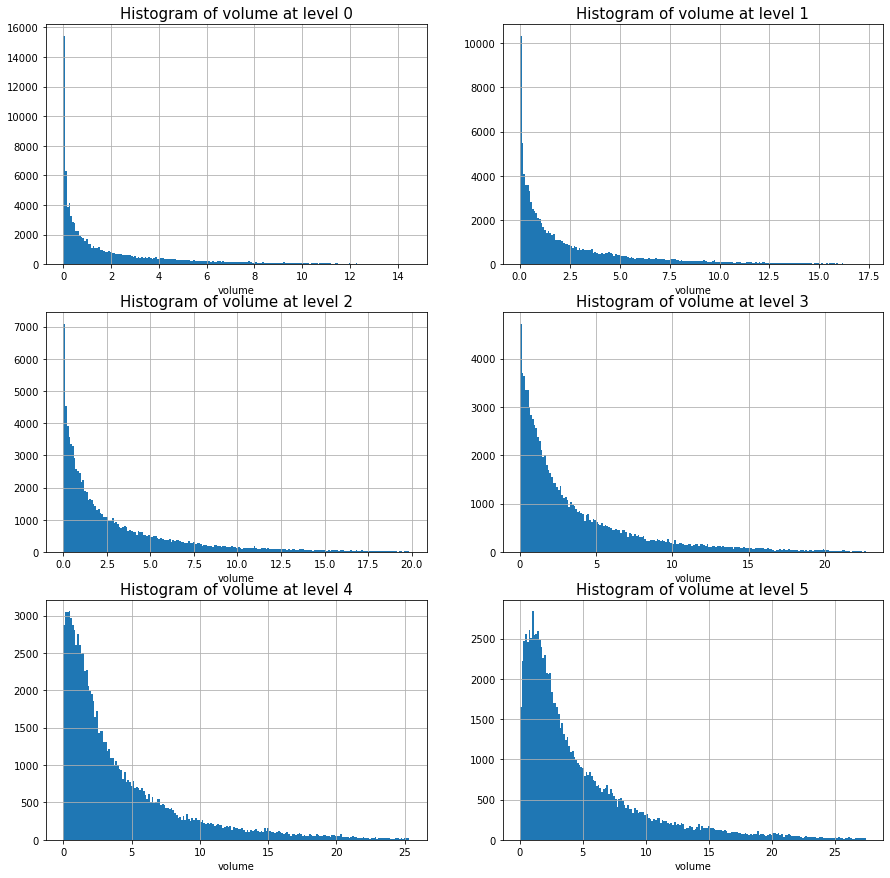

In [80]:
plot_volume_hist(ask_lobs)

In [114]:
def foo(df):
    d = {}
    d['size'] = df['size'].sum()
    d['mean_price'] = (df['size'] * df['price']).sum() / d['size'] 
    d['first_price'] = np.min(df['price'])
    d['last_price'] = np.max(df['price'])
    d['delta'] = d['last_price'] - d['first_price']
    d['n_trades'] = df['size'].count()
    d['nunique_price'] = df['price'].nunique()
    return pd.Series(d, index=['size', 'mean_price', 'first_price', 'last_price', 'delta','n_trades', 'nunique_price'])

In [138]:
ask_size = ask_trades_group["size"]
bid_size = bid_trades_group["size"]

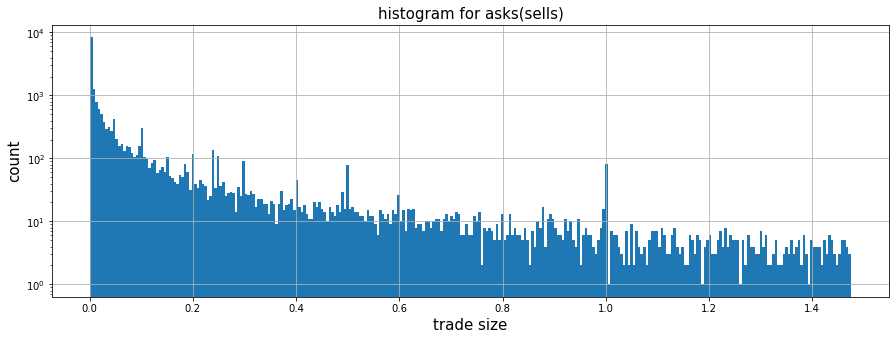

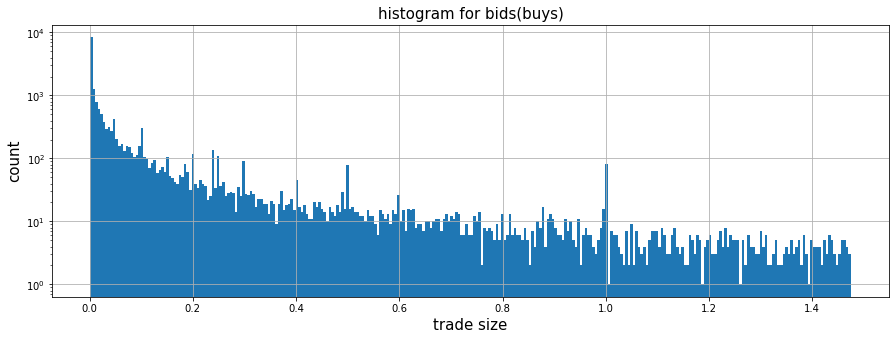

In [139]:
q1 = np.quantile(ask_size, 0.95)
q2 = np.quantile(bid_size, 0.95)

plt.figure(figsize=(15, 5))
plt.hist(ask_size[ask_size < q1], bins=300, log=True)
plt.title("histogram for asks(sells)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()
plt.figure(figsize=(15, 5))
plt.hist(bid_size[bid_size < q2], bins=300, log=True)
plt.title("histogram for bids(buys)", fontsize=15 )
plt.xlabel("trade size", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.grid()

In [115]:
bid_trades_group = bid_trades.groupby(["exchange_dt"]).apply(foo)
ask_trades_group = bid_trades.groupby(["exchange_dt"]).apply(foo)

In [116]:
bid_trades_group.head()

,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
exchange_dt,,,,,,,
2022-06-23 00:00:02.623,0.001,19977.500000,19977.5,19977.5,0.0,1.0,1.0
2022-06-23 00:00:05.292,0.086,19977.530233,19977.5,19978.0,0.5,7.0,4.0
2022-06-23 00:00:09.193,0.150,19978.000000,19978.0,19978.0,0.0,4.0,1.0
2022-06-23 00:00:09.198,0.199,19978.000000,19978.0,19978.0,0.0,1.0,1.0
2022-06-23 00:00:09.202,0.167,19978.000000,19978.0,19978.0,0.0,3.0,1.0


In [117]:
ask_trades_group.head()

,size,mean_price,first_price,last_price,delta,n_trades,nunique_price
exchange_dt,,,,,,,
2022-06-23 00:00:02.623,0.001,19977.500000,19977.5,19977.5,0.0,1.0,1.0
2022-06-23 00:00:05.292,0.086,19977.530233,19977.5,19978.0,0.5,7.0,4.0
2022-06-23 00:00:09.193,0.150,19978.000000,19978.0,19978.0,0.0,4.0,1.0
2022-06-23 00:00:09.198,0.199,19978.000000,19978.0,19978.0,0.0,1.0,1.0
2022-06-23 00:00:09.202,0.167,19978.000000,19978.0,19978.0,0.0,3.0,1.0


In [118]:
trades_.head()

,receive_ts,exchange_ts,aggro_side,price,size,exchange_dt
0,1655942402624789714,1655942402623000000,BID,19977.5,0.001,2022-06-23 00:00:02.623
1,1655942405293556247,1655942405292000000,BID,19977.5,0.041,2022-06-23 00:00:05.292
2,1655942405293628020,1655942405292000000,BID,19977.5,0.036,2022-06-23 00:00:05.292
3,1655942405293832021,1655942405292000000,BID,19977.5,0.001,2022-06-23 00:00:05.292
4,1655942405293929517,1655942405292000000,BID,19977.5,0.001,2022-06-23 00:00:05.292


In [119]:
agro_buy_df = pd.merge_asof(bid_trades_group, ask_lobs, on="exchange_dt").set_index("exchange_dt")

agro_sell_df = pd.merge_asof(ask_trades_group, ask_lobs, on="exchange_dt").set_index("exchange_dt")

In [120]:
pd.set_option('display.max_columns', None)

In [121]:
agro_buy_df.head(20)

,size,mean_price,first_price,last_price,delta,n_trades,nunique_price,price_0,vol_0,price_1,vol_1,price_2,vol_2,price_3,vol_3,price_4,vol_4,price_5,vol_5,price_6,vol_6,price_7,vol_7,price_8,vol_8,price_9,vol_9,vol_cum_0,vol_cum_1,vol_cum_2,vol_cum_3,vol_cum_4,vol_cum_5,vol_cum_6,vol_cum_7,vol_cum_8,vol_cum_9
exchange_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.623,0.001,19977.500000,19977.5,19977.5,0.0,1.0,1.0,19977.5,0.079,19977.8,0.003,19977.9,0.003,19978.0,1.283,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.117,19980.1,0.010,19980.2,0.010,0.079,0.082,0.085,1.368,1.369,1.981,2.197,3.314,3.324,3.334
2022-06-23 00:00:05.292,0.086,19977.530233,19977.5,19978.0,0.5,7.0,4.0,19977.5,0.079,19977.8,0.003,19977.9,0.003,19978.0,1.283,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,0.079,0.082,0.085,1.368,1.369,1.981,2.197,3.914,3.924,3.934
2022-06-23 00:00:09.193,0.150,19978.000000,19978.0,19978.0,0.0,4.0,1.0,19978.0,1.282,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,1.282,1.283,1.895,2.111,3.828,3.838,3.848,4.633,4.635,4.646
2022-06-23 00:00:09.198,0.199,19978.000000,19978.0,19978.0,0.0,1.0,1.0,19978.0,1.282,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,1.282,1.283,1.895,2.111,3.828,3.838,3.848,4.633,4.635,4.646
2022-06-23 00:00:09.202,0.167,19978.000000,19978.0,19978.0,0.0,3.0,1.0,19978.0,0.933,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,0.933,0.934,1.546,1.762,3.479,3.489,3.499,4.284,4.286,4.297
2022-06-23 00:00:09.215,0.040,19978.000000,19978.0,19978.0,0.0,1.0,1.0,19978.0,0.766,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,0.766,0.767,1.379,1.595,3.312,3.322,3.332,4.117,4.119,4.130
2022-06-23 00:00:09.256,0.038,19978.000000,19978.0,19978.0,0.0,2.0,1.0,19978.0,0.726,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,0.726,0.727,1.339,1.555,3.272,3.282,3.292,4.077,4.079,4.090
2022-06-23 00:00:09.258,0.062,19978.000000,19978.0,19978.0,0.0,1.0,1.0,19978.0,0.726,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,0.726,0.727,1.339,1.555,3.272,3.282,3.292,4.077,4.079,4.090
2022-06-23 00:00:09.270,0.085,19978.000000,19978.0,19978.0,0.0,1.0,1.0,19978.0,0.626,19978.5,0.001,19979.0,0.612,19979.2,0.216,19980.0,1.717,19980.1,0.010,19980.2,0.010,19980.7,0.785,19980.8,0.002,19981.0,0.011,0.626,0.627,1.239,1.455,3.172,3.182,3.192,3.977,3.979,3.990


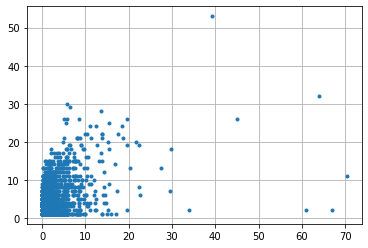

In [122]:
plt.plot(agro_buy_df["size"], agro_buy_df["nunique_price"], '.')
plt.grid()

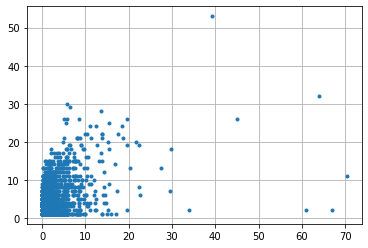

In [123]:
plt.plot(agro_sell_df["size"], agro_sell_df["nunique_price"], '.')
plt.grid()

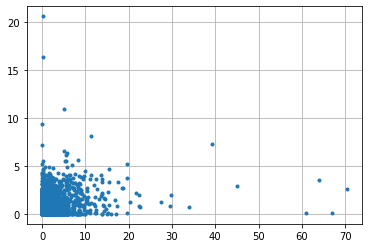

In [124]:
plt.plot(agro_sell_df["size"], agro_sell_df["last_price"]-agro_sell_df["first_price"], '.')
plt.grid()

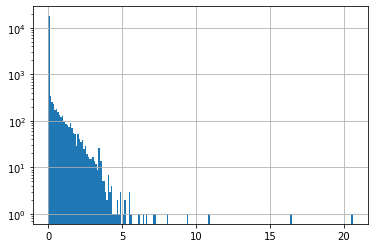

In [137]:
plt.hist(agro_sell_df["last_price"]-agro_sell_df["first_price"], log=True, bins=200)
plt.grid()
None